# Library Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import time
from torchvision import datasets, transforms
from model_utils import evaluate_model, train_model, copy_files, save_checkpoint, plot_conf_matrix, plot_evaluation, InitialChessClassifier, ChessClassifierWithBatchNorm
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

2024-05-18 16:59:43.276889: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Stage 1: Initial training

## In this stage, I trained the model with basic data augmentation techniques and evaluate the performance.

# Data Preparation


## 1. Define target size and paths

In [2]:
target_size = (224, 224)
data_dir = '/Users/akeemashaolu/Developments/personal/aiml_projects/chess_image_classification/chess_image_classifier/Chess'
class_folders = ['Bishop', 'King', 'Knight', 'Pawn', 'Queen', 'Rook']

## 2. Create directory for splitting data

In [3]:
split_data_dir = 'chess_data_split'
train_dir = os.path.join(split_data_dir, 'train')
val_dir = os.path.join(split_data_dir, 'val')
test_dir = os.path.join(split_data_dir, 'test')

for path in [train_dir, val_dir, test_dir]:
    os.makedirs(path, exist_ok=True)
    for class_folder in class_folders:
        os.makedirs(os.path.join(path, class_folder), exist_ok=True)

## 3. Load image path and labels

In [4]:
img_paths = []
labels = []

for class_folder in class_folders:
    folder_path = os.path.join(data_dir, class_folder)
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        img_paths.append(img_path)
        labels.append(class_folder)

## 4. Split data into training, validation, and test sets

In [5]:
X_train, X_test, y_train, y_test = train_test_split(img_paths, labels, test_size=0.2, random_state=42, stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42, stratify=y_train)

## 5. Copy files to the split directories

In [6]:
copy_files(X_train, y_train, train_dir)
copy_files(X_val, y_val, val_dir)
copy_files(X_test, y_test, test_dir)

## 6. Initial data augmentation

In [7]:
initial_data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(target_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Grayscale(num_output_channels=3),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(target_size),
        transforms.CenterCrop(target_size),
        transforms.ToTensor(),
        transforms.Grayscale(num_output_channels=3),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(target_size),
        transforms.CenterCrop(target_size),
        transforms.ToTensor(),
        transforms.Grayscale(num_output_channels=3),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}

## 7. Create datasets

In [8]:
initial_image_datasets = {x: datasets.ImageFolder(os.path.join(split_data_dir, x), initial_data_transforms[x]) for x in ['train', 'val', 'test']}

## 8. Create Data Loaders

In [9]:
initial_dataloaders = {x: DataLoader(initial_image_datasets[x], batch_size=32, shuffle=True, num_workers=4) for x in ['train', 'val', 'test']}

# Training

## 1. Define baseline model

In [10]:
initial_model = InitialChessClassifier()

/Users/akeemashaolu/Developments/personal/aiml_projects/chess_image_classification/chess_image_classifier/.venv/lib/python3.12/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.pytorch.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


## 2. Define loss function

In [11]:
initial_criterion = nn.CrossEntropyLoss()

## 3. Define optimizer

In [12]:
initial_optimizer = optim.Adam(initial_model.parameters(), lr=0.001) 

## 4. Define scheduler

In [13]:
initial_scheduler = torch.optim.lr_scheduler.StepLR(initial_optimizer, step_size=7, gamma=0.1)

## 5. Train the model

In [14]:
initial_trained_model, initial_train_losses, initial_train_accuracies, initial_val_losses, initial_val_accuracies, initial_best_epoch = train_model(initial_model, initial_criterion, initial_optimizer, initial_dataloaders, initial_image_datasets, num_epochs=10, scheduler=initial_scheduler)

Epoch 0/9
----------
train Loss: 6.8718 Acc: 0.2620
val Loss: 2.5385 Acc: 0.3023
Epoch 1/9
----------
train Loss: 1.8885 Acc: 0.3526
val Loss: 1.3045 Acc: 0.4419
Epoch 2/9
----------
train Loss: 1.4117 Acc: 0.4534
val Loss: 1.0064 Acc: 0.6744
Epoch 3/9
----------
train Loss: 1.3439 Acc: 0.4861
val Loss: 1.0014 Acc: 0.6512
Epoch 4/9
----------
train Loss: 1.2927 Acc: 0.5063
val Loss: 0.9532 Acc: 0.6512
Epoch 5/9
----------
train Loss: 1.3124 Acc: 0.4937
val Loss: 0.9659 Acc: 0.6047
Epoch 6/9
----------
train Loss: 1.3020 Acc: 0.4937
val Loss: 0.9298 Acc: 0.6047
Epoch 7/9
----------
train Loss: 1.1933 Acc: 0.5239
val Loss: 0.9232 Acc: 0.6047
Epoch 8/9
----------
train Loss: 1.1605 Acc: 0.5189
val Loss: 0.9322 Acc: 0.6512
Epoch 9/9
----------
train Loss: 1.1645 Acc: 0.5416
val Loss: 0.9008 Acc: 0.6279
Training complete in 21m 26s
Best val Acc: 0.6744


# Model Evaluation

## 1. Evaluation

In [15]:
initial_report, initial_conf_matrix = evaluate_model(initial_trained_model, initial_dataloaders, class_folders)

## 2. Save checkpoint

In [16]:
checkpoint_base_path = "/Users/akeemashaolu/Developments/personal/aiml_projects/chess_image_classification/chess_image_classifier/checkpoints/checkpoint"
current_time = time.time()
formatted_time = time.strftime("%H:%M:%S", time.localtime(current_time))
checkpoint_path = f'{checkpoint_base_path}-epoch({initial_best_epoch})-{formatted_time}.pth'
save_checkpoint(model=initial_trained_model, dataloader=initial_dataloaders, epoch=initial_best_epoch, train_acc=initial_train_accuracies, train_losses=initial_train_losses, val_acc=initial_val_accuracies, val_losses=initial_val_losses, checkpoint_path=checkpoint_path)

## 3. Plot precision, recall, and F1-score

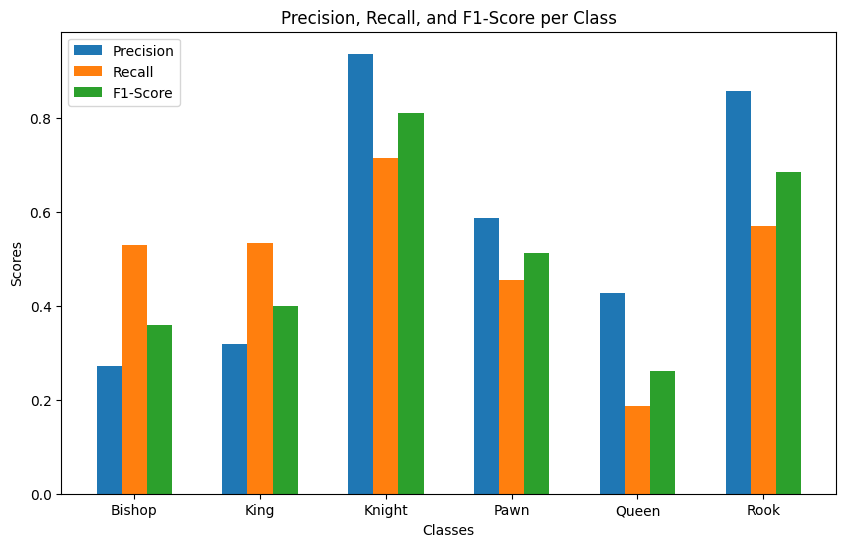

In [18]:
initial_precision = [initial_report[class_name]['precision'] for class_name in class_folders]
initial_recall = [initial_report[class_name]['recall'] for class_name in class_folders]
initial_f1_score = [initial_report[class_name]['f1-score'] for class_name in class_folders]
plot_evaluation(precision=initial_precision, recall=initial_recall, f1_score=initial_f1_score, class_folders=class_folders, img_name="initial_results_plot")

## 4. Plot confusion matrix

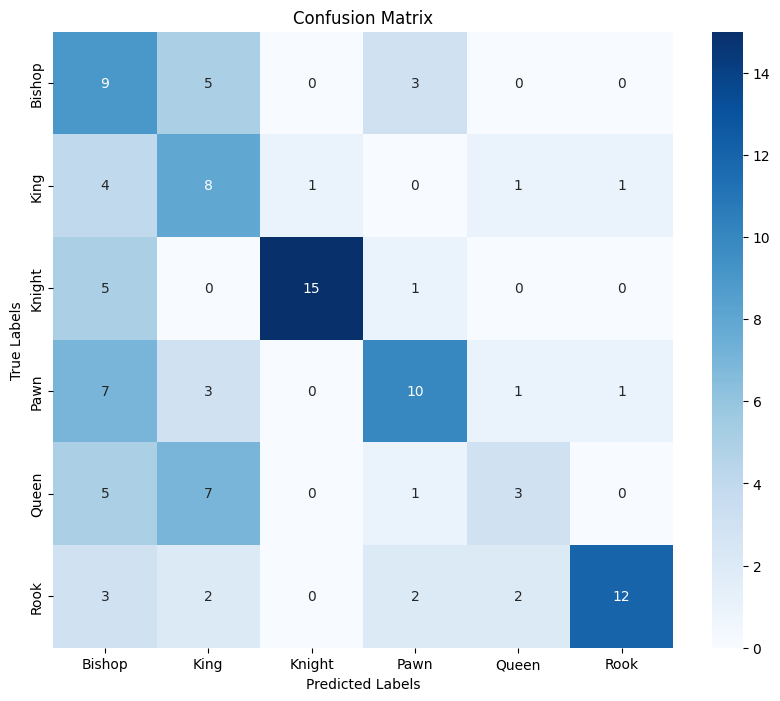

In [19]:
plot_conf_matrix(class_folders=class_folders, conf_matrix=initial_conf_matrix, img_name="initial_confusion_matrix_plot")

# Stage 2: Training with Additional Data Augmentation and Batch Normalization

## In this stage, I enhanced the data augmentation techniques and introduced batch normalization to the model.

# Data Preparation with enhancements

## 1. Enhanced data augmentation (added rotation)

In [20]:
enhanced_data_transforms_with_batch_norm = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(target_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10), # new addition
        transforms.ToTensor(),
        transforms.Grayscale(num_output_channels=3),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(target_size),
        transforms.CenterCrop(target_size),
        transforms.ToTensor(),
        transforms.Grayscale(num_output_channels=3),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(target_size),
        transforms.CenterCrop(target_size),
        transforms.ToTensor(),
        transforms.Grayscale(num_output_channels=3),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}

## 2. Create datasets

In [21]:
image_datasets_with_batch_norm = {x: datasets.ImageFolder(os.path.join(split_data_dir, x), enhanced_data_transforms_with_batch_norm[x]) for x in ['train', 'val', 'test']}

## 3. Create dataloader

In [22]:
dataloaders_with_batch_norm = {x: DataLoader(image_datasets_with_batch_norm[x], batch_size=32, shuffle=True, num_workers=4) for x in ['train', 'val', 'test']}

# Training

## 1. Define baseline model

In [23]:
model_with_batch_norm = ChessClassifierWithBatchNorm()

/Users/akeemashaolu/Developments/personal/aiml_projects/chess_image_classification/chess_image_classifier/.venv/lib/python3.12/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.pytorch.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


## 2. Define loss function

In [24]:
criterion_with_batch_norm = nn.CrossEntropyLoss()

## 3. Define Optimizer

In [25]:
optimizer_with_batch_norm = optim.Adam(model_with_batch_norm.parameters(), lr=0.001)

## 4. Define scheduler

In [26]:
scheduler_with_batch_norm = torch.optim.lr_scheduler.StepLR(optimizer_with_batch_norm, step_size=7, gamma=0.1)

## 5. Train the model

In [27]:
trained_model_with_batch_norm, train_losses_with_batch_norm, train_accuracies_with_batch_norm, val_losses_with_batch_norm, val_accuracies_with_batch_norm, best_epoch_with_batch_norm = train_model(model_with_batch_norm, criterion_with_batch_norm, optimizer_with_batch_norm, dataloaders_with_batch_norm, image_datasets_with_batch_norm, num_epochs=10, scheduler=scheduler_with_batch_norm)

Epoch 0/9
----------
train Loss: 1.6666 Acc: 0.3401
val Loss: 1.2721 Acc: 0.5349
Epoch 1/9
----------
train Loss: 1.3837 Acc: 0.4861
val Loss: 1.1609 Acc: 0.5581
Epoch 2/9
----------
train Loss: 1.3601 Acc: 0.4761
val Loss: 1.1479 Acc: 0.5581
Epoch 3/9
----------
train Loss: 1.3410 Acc: 0.4987
val Loss: 1.1828 Acc: 0.5581
Epoch 4/9
----------
train Loss: 1.4229 Acc: 0.4534
val Loss: 1.1351 Acc: 0.6047
Epoch 5/9
----------
train Loss: 1.2900 Acc: 0.5189
val Loss: 1.1781 Acc: 0.5581
Epoch 6/9
----------
train Loss: 1.3054 Acc: 0.4937
val Loss: 1.1614 Acc: 0.5581
Epoch 7/9
----------
train Loss: 1.2782 Acc: 0.5416
val Loss: 1.1205 Acc: 0.6279
Epoch 8/9
----------
train Loss: 1.1901 Acc: 0.5970
val Loss: 1.1059 Acc: 0.6047
Epoch 9/9
----------
train Loss: 1.2622 Acc: 0.5592
val Loss: 1.0962 Acc: 0.6279
Training complete in 19m 47s
Best val Acc: 0.6279


# Model Evaluation

## 1. Evaluation

In [28]:
report_with_batch_norm, conf_matrix_with_batch_norm = evaluate_model(trained_model_with_batch_norm, dataloaders_with_batch_norm, class_folders)

## 2. Save checkpoint

In [29]:
checkpoint_base_path = "/Users/akeemashaolu/Developments/personal/aiml_projects/chess_image_classification/chess_image_classifier/checkpoints/checkpoint"
current_time = time.time()
formatted_time = time.strftime("%H:%M:%S", time.localtime(current_time))
checkpoint_path = f'{checkpoint_base_path}-epoch({best_epoch_with_batch_norm})-{formatted_time}.pth'
save_checkpoint(model=trained_model_with_batch_norm, dataloader=dataloaders_with_batch_norm, epoch=best_epoch_with_batch_norm, train_acc=train_accuracies_with_batch_norm, train_losses=train_losses_with_batch_norm, val_acc=val_accuracies_with_batch_norm, val_losses=val_losses_with_batch_norm, checkpoint_path=checkpoint_path)

## 3. Plot precision, recall, and F1-score

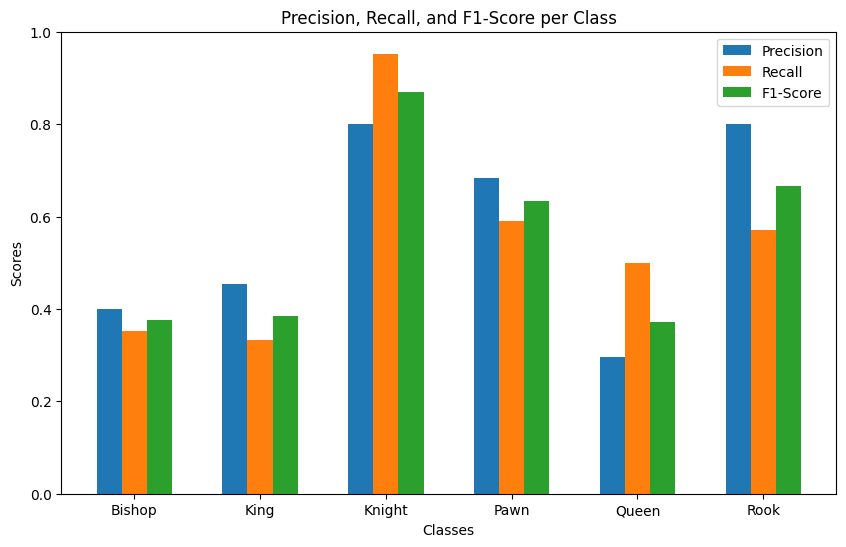

In [30]:
precision_with_batch_norm = [report_with_batch_norm[class_name]['precision'] for class_name in class_folders]
recall_with_batch_norm = [report_with_batch_norm[class_name]['recall'] for class_name in class_folders]
f1_score_with_batch_norm = [report_with_batch_norm[class_name]['f1-score'] for class_name in class_folders]
plot_evaluation(precision=precision_with_batch_norm, recall=recall_with_batch_norm, f1_score=f1_score_with_batch_norm, class_folders=class_folders, img_name="results_with_batch_norm_plot")

## 4. Plot confusion matrix

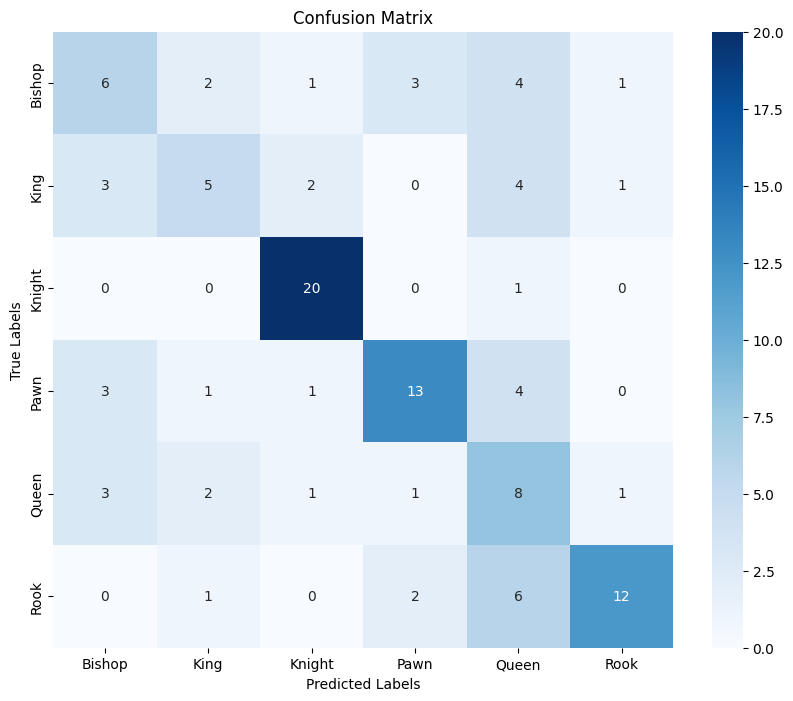

In [31]:
plot_conf_matrix(class_folders=class_folders, conf_matrix=conf_matrix_with_batch_norm, img_name="confusion_matrix_with_batch_norm_plot")

# Stage 3: Hyperparameter tuning (Learning rate and batch size)

## In this stage, I adjusted the learning rate and batch size to fine-tune the model further.

## 1. Define hyperparameters

In [32]:
learning_rates = [0.01, 0.1]
batch_sizes = [64, 128]

## 2. Tuning and training loop

Experimenting with Learning Rate: 0.01, Batch Size: 64
Epoch 0/9
----------
train Loss: 1.6143 Acc: 0.3476
val Loss: 3.5936 Acc: 0.3721
Epoch 1/9
----------
train Loss: 1.4247 Acc: 0.4332
val Loss: 1.6767 Acc: 0.4419
Epoch 2/9
----------
train Loss: 1.3421 Acc: 0.5063
val Loss: 1.2211 Acc: 0.4651
Epoch 3/9
----------
train Loss: 1.3908 Acc: 0.4685
val Loss: 1.1148 Acc: 0.4651
Epoch 4/9
----------
train Loss: 1.3469 Acc: 0.4710
val Loss: 1.0484 Acc: 0.6047
Epoch 5/9
----------
train Loss: 1.2673 Acc: 0.5214
val Loss: 1.0894 Acc: 0.5349
Epoch 6/9
----------
train Loss: 1.2424 Acc: 0.5088
val Loss: 1.0725 Acc: 0.6047
Epoch 7/9
----------
train Loss: 1.2594 Acc: 0.5214
val Loss: 1.0681 Acc: 0.5581
Epoch 8/9
----------
train Loss: 1.2261 Acc: 0.5491
val Loss: 1.0626 Acc: 0.5814
Epoch 9/9
----------
train Loss: 1.1955 Acc: 0.5567
val Loss: 1.0687 Acc: 0.5581
Training complete in 26m 23s
Best val Acc: 0.6047


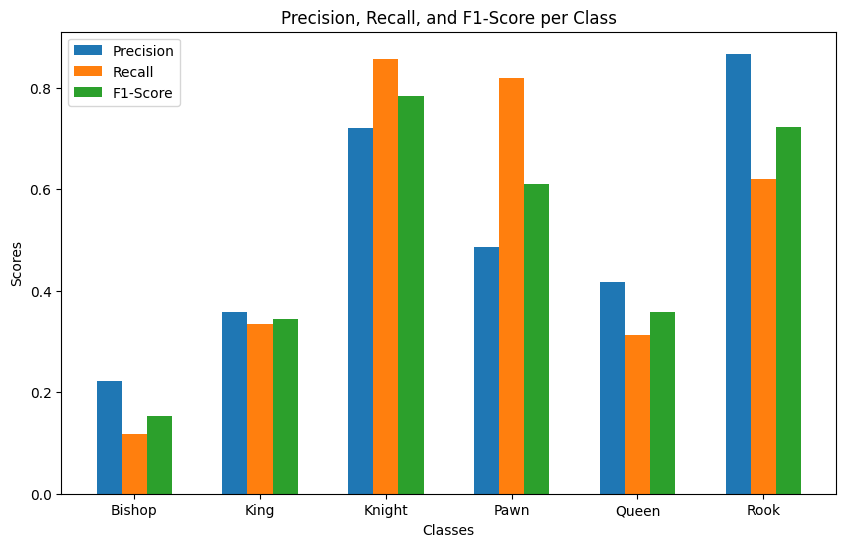

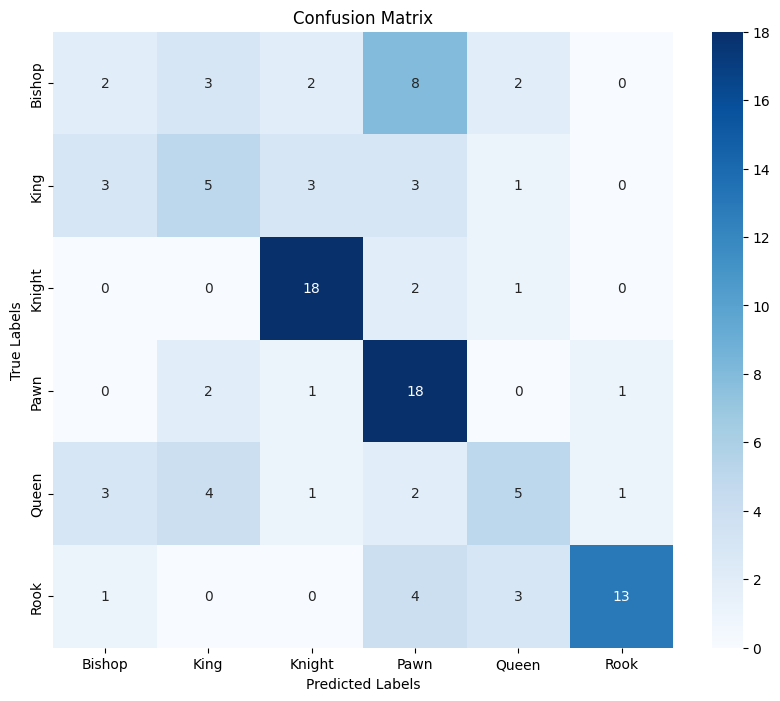

Experimenting with Learning Rate: 0.01, Batch Size: 128
Epoch 0/9
----------
train Loss: 1.3360 Acc: 0.4736
val Loss: 1.1364 Acc: 0.6279
Epoch 1/9
----------
train Loss: 1.2345 Acc: 0.5567
val Loss: 1.2317 Acc: 0.5116
Epoch 2/9
----------
train Loss: 1.2808 Acc: 0.5063
val Loss: 1.3187 Acc: 0.4651
Epoch 3/9
----------
train Loss: 1.2911 Acc: 0.4786
val Loss: 1.1820 Acc: 0.5581
Epoch 4/9
----------
train Loss: 1.3257 Acc: 0.4610
val Loss: 1.1240 Acc: 0.5814
Epoch 5/9
----------
train Loss: 1.2409 Acc: 0.5516
val Loss: 1.1024 Acc: 0.6047
Epoch 6/9
----------
train Loss: 1.2436 Acc: 0.5340
val Loss: 1.0762 Acc: 0.6047
Epoch 7/9
----------
train Loss: 1.2384 Acc: 0.5542
val Loss: 1.0650 Acc: 0.6279
Epoch 8/9
----------
train Loss: 1.2349 Acc: 0.5416
val Loss: 1.0542 Acc: 0.6279
Epoch 9/9
----------
train Loss: 1.2407 Acc: 0.5063
val Loss: 1.0458 Acc: 0.6279
Training complete in 100m 54s
Best val Acc: 0.6279


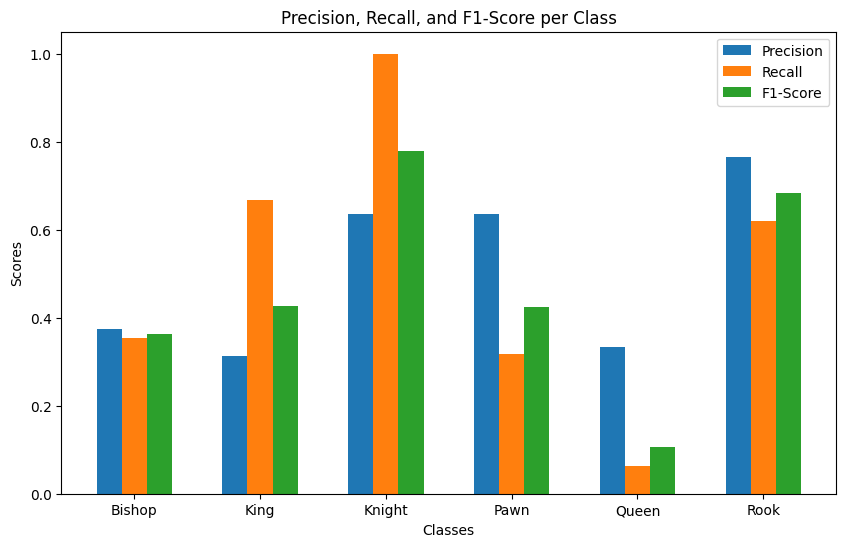

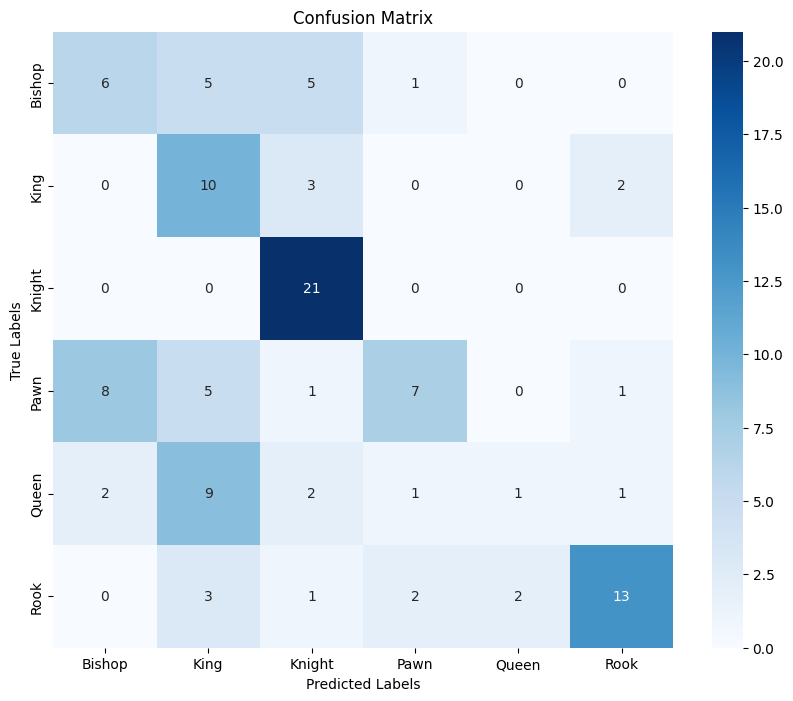

Experimenting with Learning Rate: 0.1, Batch Size: 64
Epoch 0/9
----------
train Loss: 1.7030 Acc: 0.3350
val Loss: 2.8647 Acc: 0.3953
Epoch 1/9
----------
train Loss: 1.4797 Acc: 0.4635
val Loss: 1.3315 Acc: 0.5349
Epoch 2/9
----------
train Loss: 1.3944 Acc: 0.4433
val Loss: 1.1386 Acc: 0.5116
Epoch 3/9
----------
train Loss: 1.3501 Acc: 0.4912
val Loss: 1.1068 Acc: 0.4884
Epoch 4/9
----------
train Loss: 1.3087 Acc: 0.4811
val Loss: 1.1815 Acc: 0.5581
Epoch 5/9
----------
train Loss: 1.3220 Acc: 0.4635
val Loss: 1.2725 Acc: 0.5116
Epoch 6/9
----------
train Loss: 1.2328 Acc: 0.5189
val Loss: 1.1008 Acc: 0.5349
Epoch 7/9
----------
train Loss: 1.2388 Acc: 0.5139
val Loss: 1.0694 Acc: 0.5814
Epoch 8/9
----------
train Loss: 1.1795 Acc: 0.5491
val Loss: 1.0582 Acc: 0.5814
Epoch 9/9
----------
train Loss: 1.2412 Acc: 0.5013
val Loss: 1.0481 Acc: 0.5814
Training complete in 21m 59s
Best val Acc: 0.5814


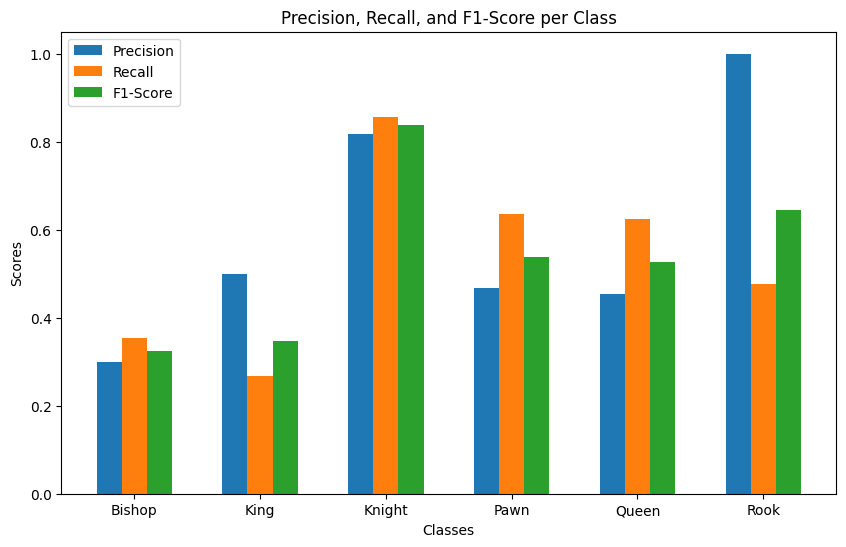

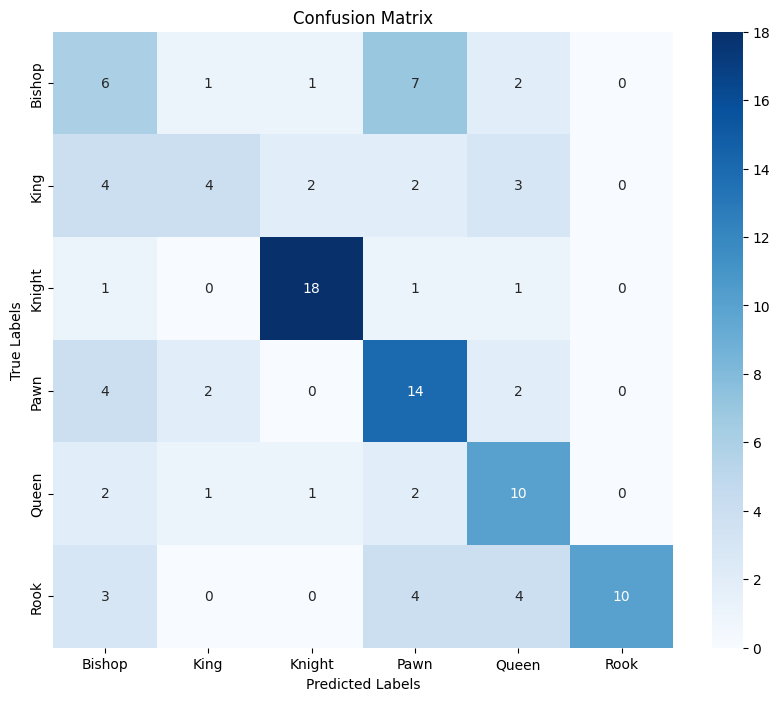

Experimenting with Learning Rate: 0.1, Batch Size: 128
Epoch 0/9
----------
train Loss: 1.3130 Acc: 0.4887
val Loss: 1.0812 Acc: 0.5349
Epoch 1/9
----------
train Loss: 1.2348 Acc: 0.5063
val Loss: 1.0520 Acc: 0.5581
Epoch 2/9
----------
train Loss: 1.2940 Acc: 0.4584
val Loss: 1.0305 Acc: 0.6047
Epoch 3/9
----------
train Loss: 1.2439 Acc: 0.5290
val Loss: 0.9973 Acc: 0.6512
Epoch 4/9
----------
train Loss: 1.2007 Acc: 0.5516
val Loss: 1.0234 Acc: 0.6047
Epoch 5/9
----------
train Loss: 1.2316 Acc: 0.4912
val Loss: 0.9924 Acc: 0.6047
Epoch 6/9
----------
train Loss: 1.2177 Acc: 0.5617
val Loss: 0.9700 Acc: 0.6279
Epoch 7/9
----------
train Loss: 1.1976 Acc: 0.5567
val Loss: 0.9817 Acc: 0.6047
Epoch 8/9
----------
train Loss: 1.2029 Acc: 0.5516
val Loss: 1.0001 Acc: 0.6279
Epoch 9/9
----------
train Loss: 1.2333 Acc: 0.5013
val Loss: 0.9900 Acc: 0.6279
Training complete in 21m 55s
Best val Acc: 0.6512


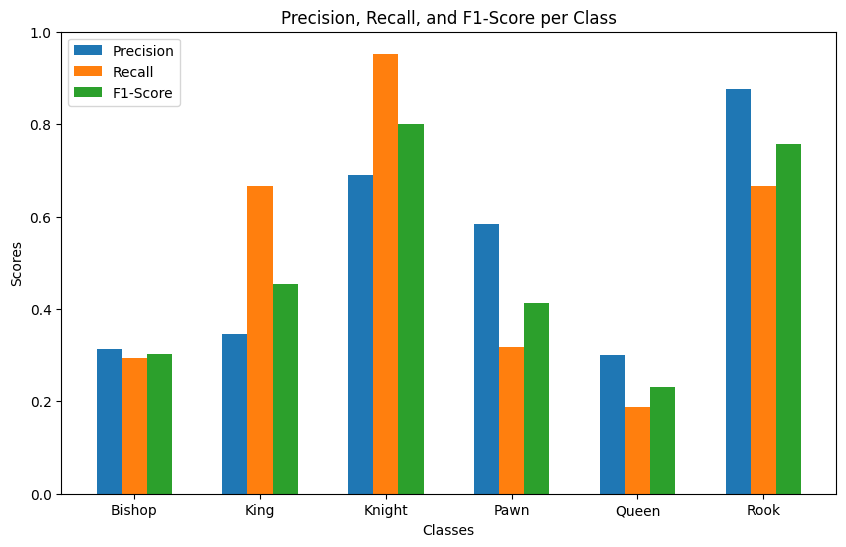

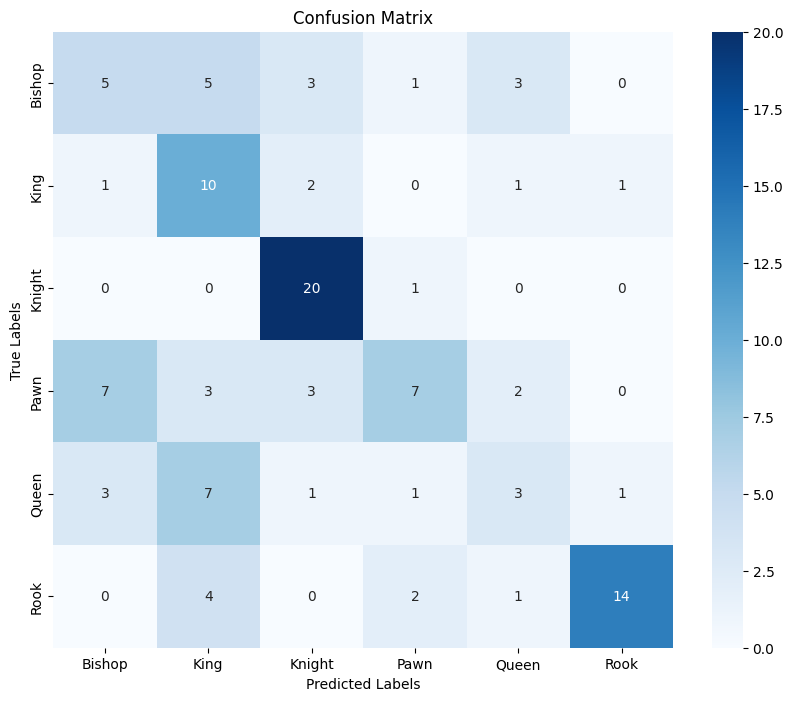

In [33]:
for lr in learning_rates:
    for batch_size in batch_sizes:
        # Implement tuning
        dataloaders_with_tuning = {x: DataLoader(image_datasets_with_batch_norm[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val', 'test']}
        optimizer_with_tuning = optim.Adam(model_with_batch_norm.parameters(), lr=lr)
        scheduler_with_tuning = torch.optim.lr_scheduler.StepLR(optimizer_with_tuning, step_size=7, gamma=0.1)
        print(f'Experimenting with Learning Rate: {lr}, Batch Size: {batch_size}')

        # Train model
        trained_model_with_tuning, train_losses_with_tuning, train_accuracies_with_tuning, val_losses_with_tuning, val_accuracies_with_tuning, best_epoch_with_tuning = train_model(model_with_batch_norm, criterion_with_batch_norm, optimizer_with_tuning, dataloaders_with_tuning, image_datasets_with_batch_norm, num_epochs=10, scheduler=scheduler_with_tuning)

        # Evaluate model
        report_with_tuning, conf_matrix_with_tuning = evaluate_model(trained_model_with_tuning, dataloaders_with_tuning, class_folders)
        
        # Save checkpoint
        checkpoint_base_path = "/Users/akeemashaolu/Developments/personal/aiml_projects/chess_image_classification/chess_image_classifier/checkpoints/checkpoint"
        current_time = time.time()
        formatted_time = time.strftime("%H:%M:%S", time.localtime(current_time))
        checkpoint_path = f'{checkpoint_base_path}-epoch({best_epoch_with_tuning})-lr({lr})-bs({batch_size})-{formatted_time}.pth'
        save_checkpoint(model=trained_model_with_tuning, dataloader=dataloaders_with_tuning, epoch=best_epoch_with_tuning, train_acc=train_accuracies_with_tuning, train_losses=train_losses_with_tuning, val_acc=val_accuracies_with_tuning, val_losses=val_losses_with_tuning, checkpoint_path=checkpoint_path)

        # Plot precision, recall, and F1-score
        precision_with_tuning = [report_with_tuning[class_name]['precision'] for class_name in class_folders]
        recall_with_tuning = [report_with_tuning[class_name]['recall'] for class_name in class_folders]
        f1_score_with_tuning = [report_with_tuning[class_name]['f1-score'] for class_name in class_folders]
        plot_evaluation(precision=precision_with_tuning, recall=recall_with_tuning, f1_score=f1_score_with_tuning, class_folders=class_folders, img_name="results_with_tuning_plot")

        # Plot confusion matrix
        plot_conf_matrix(class_folders=class_folders, conf_matrix=conf_matrix_with_tuning, img_name="confusion_matrix_with_tuning_plot")